In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[9].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:08<00:00,  3.41it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:04<00:00, 51.23it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:22<00:00,  2.93it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:02<00:00, 96.65it/s] 


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:00<01:26, 22.93it/s]

Epoch 10/2000, Loss: 0.6244
Test Accuracy at Epoch 10: 63.16%
Test F1-score at Epoch 10: 0.6667
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       194
non_infringement       0.60      0.75      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380

New best model saved with F1-score 0.6667 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.52      0.59       194
non_infringement       0.60      0.75      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380



Training Epochs:   1%|▏         | 25/2000 [00:01<01:24, 23.31it/s]

Epoch 20/2000, Loss: 0.4782
Test Accuracy at Epoch 20: 70.79%
Test F1-score at Epoch 20: 0.7613
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.91      0.47      0.62       194
non_infringement       0.63      0.95      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.71      0.69       380
    weighted avg       0.78      0.71      0.69       380

New best model saved with F1-score 0.7613 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.91      0.47      0.62       194
non_infringement       0.63      0.95      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.71      0.69       380
    weighted avg       0.78      0.71      0.69       380



Training Epochs:   2%|▏         | 32/2000 [00:01<01:59, 16.48it/s]

Epoch 30/2000, Loss: 0.3781
Test Accuracy at Epoch 30: 74.74%
Test F1-score at Epoch 30: 0.7798
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.88      0.59      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380

New best model saved with F1-score 0.7798 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.88      0.59      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:   2%|▏         | 39/2000 [00:02<03:56,  8.29it/s]

Epoch 40/2000, Loss: 0.3219
Test Accuracy at Epoch 40: 78.68%
Test F1-score at Epoch 40: 0.8076
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380

New best model saved with F1-score 0.8076 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:   3%|▎         | 51/2000 [00:04<03:08, 10.33it/s]

Epoch 50/2000, Loss: 0.2838
Test Accuracy at Epoch 50: 80.79%
Test F1-score at Epoch 50: 0.8241
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380

New best model saved with F1-score 0.8241 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:   3%|▎         | 60/2000 [00:06<06:03,  5.33it/s]

Epoch 60/2000, Loss: 0.2628
Test Accuracy at Epoch 60: 80.26%
Test F1-score at Epoch 60: 0.8139
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   3%|▎         | 69/2000 [00:07<03:31,  9.15it/s]

Epoch 70/2000, Loss: 0.2316
Test Accuracy at Epoch 70: 77.89%
Test F1-score at Epoch 70: 0.8037
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:   4%|▍         | 81/2000 [00:10<03:41,  8.66it/s]

Epoch 80/2000, Loss: 0.2124
Test Accuracy at Epoch 80: 76.32%
Test F1-score at Epoch 80: 0.7761
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   4%|▍         | 89/2000 [00:12<10:21,  3.08it/s]

Epoch 90/2000, Loss: 0.2026


Training Epochs:   4%|▍         | 90/2000 [00:13<13:44,  2.32it/s]

Test Accuracy at Epoch 90: 77.63%
Test F1-score at Epoch 90: 0.8028
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.74       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:   5%|▌         | 100/2000 [00:16<09:57,  3.18it/s]

Epoch 100/2000, Loss: 0.1828
Test Accuracy at Epoch 100: 78.16%
Test F1-score at Epoch 100: 0.8010
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.87      0.67      0.76       194
non_infringement       0.72      0.90      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:   6%|▌         | 110/2000 [00:20<07:25,  4.24it/s]

Epoch 110/2000, Loss: 0.1597
Test Accuracy at Epoch 110: 76.84%
Test F1-score at Epoch 110: 0.7982
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.91      0.61      0.73       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:   6%|▌         | 120/2000 [00:23<08:38,  3.62it/s]

Epoch 120/2000, Loss: 0.1478
Test Accuracy at Epoch 120: 76.84%
Test F1-score at Epoch 120: 0.7972
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.90      0.61      0.73       194
non_infringement       0.70      0.93      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:   6%|▋         | 130/2000 [00:27<07:57,  3.92it/s]

Epoch 130/2000, Loss: 0.1778
Test Accuracy at Epoch 130: 70.53%
Test F1-score at Epoch 130: 0.7597
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.91      0.47      0.62       194
non_infringement       0.63      0.95      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.71      0.69       380
    weighted avg       0.77      0.71      0.69       380



Training Epochs:   7%|▋         | 142/2000 [00:29<04:29,  6.90it/s]

Epoch 140/2000, Loss: 0.1449
Test Accuracy at Epoch 140: 76.84%
Test F1-score at Epoch 140: 0.7991
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.91      0.60      0.73       194
non_infringement       0.69      0.94      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.81      0.77      0.76       380



Training Epochs:   8%|▊         | 150/2000 [00:30<03:51,  7.98it/s]

Epoch 150/2000, Loss: 0.1335
Test Accuracy at Epoch 150: 76.84%
Test F1-score at Epoch 150: 0.7982
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.91      0.61      0.73       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:   8%|▊         | 160/2000 [00:35<17:34,  1.75it/s]

Epoch 160/2000, Loss: 0.1280
Test Accuracy at Epoch 160: 77.89%
Test F1-score at Epoch 160: 0.8037
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:   9%|▊         | 171/2000 [00:37<04:44,  6.42it/s]

Epoch 170/2000, Loss: 0.1212
Test Accuracy at Epoch 170: 76.58%
Test F1-score at Epoch 170: 0.7945
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.89      0.61      0.73       194
non_infringement       0.70      0.92      0.79       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:   9%|▉         | 180/2000 [00:38<03:50,  7.91it/s]

Epoch 180/2000, Loss: 0.1258
Test Accuracy at Epoch 180: 76.58%
Test F1-score at Epoch 180: 0.7835
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.84      0.67      0.74       194
non_infringement       0.72      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  10%|▉         | 190/2000 [00:39<03:14,  9.29it/s]

Epoch 190/2000, Loss: 0.1347
Test Accuracy at Epoch 190: 78.16%
Test F1-score at Epoch 190: 0.8038
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.75       194
non_infringement       0.72      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  10%|█         | 200/2000 [00:43<09:42,  3.09it/s]

Epoch 200/2000, Loss: 0.1206
Test Accuracy at Epoch 200: 77.63%
Test F1-score at Epoch 200: 0.8009
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.89      0.64      0.74       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.78      0.77       380



Training Epochs:  10%|█         | 210/2000 [00:48<16:35,  1.80it/s]

Epoch 210/2000, Loss: 0.1108
Test Accuracy at Epoch 210: 77.11%
Test F1-score at Epoch 210: 0.7972
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.89      0.63      0.74       194
non_infringement       0.70      0.92      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.77       380
    weighted avg       0.80      0.77      0.77       380



Training Epochs:  11%|█         | 220/2000 [00:53<09:26,  3.14it/s]

Epoch 220/2000, Loss: 0.1074
Test Accuracy at Epoch 220: 77.63%
Test F1-score at Epoch 220: 0.8009
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.89      0.64      0.74       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.78      0.77       380



Training Epochs:  12%|█▏        | 230/2000 [00:55<08:36,  3.43it/s]

Epoch 230/2000, Loss: 0.1031
Test Accuracy at Epoch 230: 77.63%
Test F1-score at Epoch 230: 0.8009
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.89      0.64      0.74       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.78      0.77       380



Training Epochs:  12%|█▏        | 239/2000 [00:55<02:59,  9.79it/s]

Epoch 240/2000, Loss: 0.1506
Test Accuracy at Epoch 240: 76.84%
Test F1-score at Epoch 240: 0.7982
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.91      0.61      0.73       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:  13%|█▎        | 252/2000 [01:01<07:16,  4.00it/s]

Epoch 250/2000, Loss: 0.1096
Test Accuracy at Epoch 250: 78.16%
Test F1-score at Epoch 250: 0.8029
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.88      0.66      0.76       194
non_infringement       0.72      0.91      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  13%|█▎        | 262/2000 [01:03<06:35,  4.39it/s]

Epoch 260/2000, Loss: 0.1000
Test Accuracy at Epoch 260: 78.16%
Test F1-score at Epoch 260: 0.8065
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  14%|█▎        | 270/2000 [01:05<05:15,  5.49it/s]

Epoch 270/2000, Loss: 0.0973
Test Accuracy at Epoch 270: 78.16%
Test F1-score at Epoch 270: 0.8065
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  14%|█▍        | 280/2000 [01:05<02:40, 10.74it/s]

Epoch 280/2000, Loss: 0.0952
Test Accuracy at Epoch 280: 77.89%
Test F1-score at Epoch 280: 0.8037
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  14%|█▍        | 290/2000 [01:08<06:10,  4.62it/s]

Epoch 290/2000, Loss: 0.0980
Test Accuracy at Epoch 290: 78.42%
Test F1-score at Epoch 290: 0.8029
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       194
non_infringement       0.73      0.90      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  15%|█▌        | 300/2000 [01:11<09:14,  3.07it/s]

Epoch 300/2000, Loss: 0.0942
Test Accuracy at Epoch 300: 78.68%
Test F1-score at Epoch 300: 0.8076
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  16%|█▌        | 310/2000 [01:16<13:50,  2.04it/s]

Epoch 310/2000, Loss: 0.0953
Test Accuracy at Epoch 310: 78.68%
Test F1-score at Epoch 310: 0.8085
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  16%|█▌        | 320/2000 [01:17<04:01,  6.95it/s]

Epoch 320/2000, Loss: 0.0904
Test Accuracy at Epoch 320: 78.68%
Test F1-score at Epoch 320: 0.8094
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  17%|█▋        | 332/2000 [01:18<02:28, 11.25it/s]

Epoch 330/2000, Loss: 0.0888
Test Accuracy at Epoch 330: 78.68%
Test F1-score at Epoch 330: 0.8094
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  17%|█▋        | 342/2000 [01:19<01:55, 14.35it/s]

Epoch 340/2000, Loss: 0.0871
Test Accuracy at Epoch 340: 77.89%
Test F1-score at Epoch 340: 0.8037
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  18%|█▊        | 352/2000 [01:19<02:04, 13.26it/s]

Epoch 350/2000, Loss: 0.1173
Test Accuracy at Epoch 350: 79.74%
Test F1-score at Epoch 350: 0.8060
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.85      0.74      0.79       194
non_infringement       0.76      0.86      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  18%|█▊        | 362/2000 [01:20<01:55, 14.15it/s]

Epoch 360/2000, Loss: 0.0978
Test Accuracy at Epoch 360: 79.47%
Test F1-score at Epoch 360: 0.8152
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  19%|█▊        | 372/2000 [01:21<02:21, 11.51it/s]

Epoch 370/2000, Loss: 0.0872
Test Accuracy at Epoch 370: 77.63%
Test F1-score at Epoch 370: 0.8028
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.74       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  19%|█▉        | 382/2000 [01:22<02:04, 12.97it/s]

Epoch 380/2000, Loss: 0.0852
Test Accuracy at Epoch 380: 78.95%
Test F1-score at Epoch 380: 0.8122
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  20%|█▉        | 392/2000 [01:23<02:00, 13.33it/s]

Epoch 390/2000, Loss: 0.0839
Test Accuracy at Epoch 390: 78.68%
Test F1-score at Epoch 390: 0.8094
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.90      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  20%|██        | 400/2000 [01:23<02:53,  9.20it/s]

Epoch 400/2000, Loss: 0.0832
Test Accuracy at Epoch 400: 77.89%
Test F1-score at Epoch 400: 0.8047
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.75       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  21%|██        | 413/2000 [01:25<02:06, 12.55it/s]

Epoch 410/2000, Loss: 0.0842
Test Accuracy at Epoch 410: 79.47%
Test F1-score at Epoch 410: 0.8152
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  21%|██        | 420/2000 [01:25<01:39, 15.85it/s]

Epoch 420/2000, Loss: 0.0843
Test Accuracy at Epoch 420: 77.63%
Test F1-score at Epoch 420: 0.8028
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.74       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  22%|██▏       | 431/2000 [01:26<01:23, 18.78it/s]

Epoch 430/2000, Loss: 0.0850
Test Accuracy at Epoch 430: 79.74%
Test F1-score at Epoch 430: 0.8180
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  22%|██▏       | 443/2000 [01:26<01:23, 18.64it/s]

Epoch 440/2000, Loss: 0.0821
Test Accuracy at Epoch 440: 77.89%
Test F1-score at Epoch 440: 0.8047
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.75       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  23%|██▎       | 453/2000 [01:27<01:25, 18.00it/s]

Epoch 450/2000, Loss: 0.0829
Test Accuracy at Epoch 450: 80.00%
Test F1-score at Epoch 450: 0.8199
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  23%|██▎       | 462/2000 [01:27<01:24, 18.23it/s]

Epoch 460/2000, Loss: 0.0829
Test Accuracy at Epoch 460: 80.00%
Test F1-score at Epoch 460: 0.8199
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  24%|██▎       | 470/2000 [01:28<01:37, 15.63it/s]

Epoch 470/2000, Loss: 0.0864
Test Accuracy at Epoch 470: 82.11%
Test F1-score at Epoch 470: 0.8350
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380

New best model saved with F1-score 0.8350 at epoch 470
Best Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  24%|██▍       | 481/2000 [01:29<02:59,  8.44it/s]

Epoch 480/2000, Loss: 0.0864
Test Accuracy at Epoch 480: 76.84%
Test F1-score at Epoch 480: 0.7972
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.90      0.61      0.73       194
non_infringement       0.70      0.93      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:  25%|██▍       | 492/2000 [01:30<02:04, 12.11it/s]

Epoch 490/2000, Loss: 0.0828
Test Accuracy at Epoch 490: 80.00%
Test F1-score at Epoch 490: 0.8199
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  25%|██▌       | 502/2000 [01:31<02:06, 11.84it/s]

Epoch 500/2000, Loss: 0.0807
Test Accuracy at Epoch 500: 78.16%
Test F1-score at Epoch 500: 0.8065
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  26%|██▌       | 512/2000 [01:31<01:35, 15.52it/s]

Epoch 510/2000, Loss: 0.0806
Test Accuracy at Epoch 510: 79.74%
Test F1-score at Epoch 510: 0.8171
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  26%|██▌       | 520/2000 [01:32<01:57, 12.64it/s]

Epoch 520/2000, Loss: 0.0791
Test Accuracy at Epoch 520: 78.16%
Test F1-score at Epoch 520: 0.8065
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  27%|██▋       | 532/2000 [01:33<02:03, 11.86it/s]

Epoch 530/2000, Loss: 0.0791
Test Accuracy at Epoch 530: 79.74%
Test F1-score at Epoch 530: 0.8171
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  27%|██▋       | 542/2000 [01:34<02:13, 10.91it/s]

Epoch 540/2000, Loss: 0.0811
Test Accuracy at Epoch 540: 78.16%
Test F1-score at Epoch 540: 0.8065
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  28%|██▊       | 551/2000 [01:35<03:06,  7.78it/s]

Epoch 550/2000, Loss: 0.0792
Test Accuracy at Epoch 550: 79.47%
Test F1-score at Epoch 550: 0.8160
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  28%|██▊       | 561/2000 [01:36<03:22,  7.10it/s]

Epoch 560/2000, Loss: 0.0793
Test Accuracy at Epoch 560: 78.16%
Test F1-score at Epoch 560: 0.8065
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.75       194
non_infringement       0.71      0.93      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  28%|██▊       | 570/2000 [01:38<05:43,  4.17it/s]

Epoch 570/2000, Loss: 0.0829
Test Accuracy at Epoch 570: 77.89%
Test F1-score at Epoch 570: 0.8047
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.75       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  29%|██▉       | 580/2000 [01:42<07:08,  3.32it/s]

Epoch 580/2000, Loss: 0.0786
Test Accuracy at Epoch 580: 80.00%
Test F1-score at Epoch 580: 0.8190
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  30%|██▉       | 592/2000 [01:45<03:13,  7.27it/s]

Epoch 590/2000, Loss: 0.0791
Test Accuracy at Epoch 590: 77.89%
Test F1-score at Epoch 590: 0.8047
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.75       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  30%|███       | 600/2000 [01:48<07:21,  3.17it/s]

Epoch 600/2000, Loss: 0.0794
Test Accuracy at Epoch 600: 81.58%
Test F1-score at Epoch 600: 0.8309
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  31%|███       | 611/2000 [01:50<02:45,  8.40it/s]

Epoch 610/2000, Loss: 0.0785
Test Accuracy at Epoch 610: 78.95%
Test F1-score at Epoch 610: 0.8122
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  31%|███       | 619/2000 [01:50<01:51, 12.42it/s]

Epoch 620/2000, Loss: 0.0779
Test Accuracy at Epoch 620: 80.00%
Test F1-score at Epoch 620: 0.8190
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  32%|███▏      | 631/2000 [01:54<03:39,  6.24it/s]

Epoch 630/2000, Loss: 0.0810
Test Accuracy at Epoch 630: 81.32%
Test F1-score at Epoch 630: 0.8281
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  32%|███▏      | 642/2000 [01:57<04:01,  5.62it/s]

Epoch 640/2000, Loss: 0.0782
Test Accuracy at Epoch 640: 78.95%
Test F1-score at Epoch 640: 0.8122
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  33%|███▎      | 651/2000 [01:58<04:53,  4.59it/s]

Epoch 650/2000, Loss: 0.0770
Test Accuracy at Epoch 650: 80.00%
Test F1-score at Epoch 650: 0.8190
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  33%|███▎      | 660/2000 [02:01<07:52,  2.84it/s]

Epoch 660/2000, Loss: 0.0773
Test Accuracy at Epoch 660: 78.95%
Test F1-score at Epoch 660: 0.8122
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  34%|███▎      | 670/2000 [02:06<12:12,  1.82it/s]

Epoch 670/2000, Loss: 0.0779
Test Accuracy at Epoch 670: 81.58%
Test F1-score at Epoch 670: 0.8309
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  34%|███▍      | 680/2000 [02:12<12:21,  1.78it/s]

Epoch 680/2000, Loss: 0.0774
Test Accuracy at Epoch 680: 78.95%
Test F1-score at Epoch 680: 0.8122
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  34%|███▍      | 690/2000 [02:15<09:05,  2.40it/s]

Epoch 690/2000, Loss: 0.0769
Test Accuracy at Epoch 690: 80.00%
Test F1-score at Epoch 690: 0.8190
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  35%|███▌      | 701/2000 [02:17<03:15,  6.64it/s]

Epoch 700/2000, Loss: 0.0807
Test Accuracy at Epoch 700: 81.32%
Test F1-score at Epoch 700: 0.8273
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  36%|███▌      | 712/2000 [02:20<02:46,  7.71it/s]

Epoch 710/2000, Loss: 0.0773
Test Accuracy at Epoch 710: 78.95%
Test F1-score at Epoch 710: 0.8122
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  36%|███▌      | 724/2000 [02:21<01:50, 11.53it/s]

Epoch 720/2000, Loss: 0.0763
Test Accuracy at Epoch 720: 81.32%
Test F1-score at Epoch 720: 0.8289
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  36%|███▋      | 730/2000 [02:24<05:57,  3.55it/s]

Epoch 730/2000, Loss: 0.0762
Test Accuracy at Epoch 730: 78.95%
Test F1-score at Epoch 730: 0.8122
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  37%|███▋      | 740/2000 [02:27<10:09,  2.07it/s]

Epoch 740/2000, Loss: 0.0763
Test Accuracy at Epoch 740: 81.32%
Test F1-score at Epoch 740: 0.8289
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  38%|███▊      | 750/2000 [02:30<08:10,  2.55it/s]

Epoch 750/2000, Loss: 0.0763
Test Accuracy at Epoch 750: 78.95%
Test F1-score at Epoch 750: 0.8122
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  38%|███▊      | 762/2000 [02:33<03:22,  6.10it/s]

Epoch 760/2000, Loss: 0.0758
Test Accuracy at Epoch 760: 79.21%
Test F1-score at Epoch 760: 0.8132
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.77       194
non_infringement       0.73      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  38%|███▊      | 770/2000 [02:33<01:37, 12.59it/s]

Epoch 770/2000, Loss: 0.0778
Test Accuracy at Epoch 770: 81.32%
Test F1-score at Epoch 770: 0.8273
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  39%|███▉      | 783/2000 [02:35<02:46,  7.31it/s]

Epoch 780/2000, Loss: 0.0762
Test Accuracy at Epoch 780: 81.05%
Test F1-score at Epoch 780: 0.8269
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  40%|███▉      | 790/2000 [02:37<03:50,  5.26it/s]

Epoch 790/2000, Loss: 0.0757
Test Accuracy at Epoch 790: 78.95%
Test F1-score at Epoch 790: 0.8122
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  40%|████      | 802/2000 [02:38<02:24,  8.29it/s]

Epoch 800/2000, Loss: 0.0836
Test Accuracy at Epoch 800: 78.95%
Test F1-score at Epoch 800: 0.8122
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  41%|████      | 811/2000 [02:39<01:47, 11.04it/s]

Epoch 810/2000, Loss: 0.0783
Test Accuracy at Epoch 810: 81.05%
Test F1-score at Epoch 810: 0.8269
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  41%|████      | 821/2000 [02:40<01:37, 12.03it/s]

Epoch 820/2000, Loss: 0.0769
Test Accuracy at Epoch 820: 81.05%
Test F1-score at Epoch 820: 0.8269
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  42%|████▏     | 833/2000 [02:40<00:58, 19.82it/s]

Epoch 830/2000, Loss: 0.0754
Test Accuracy at Epoch 830: 80.79%
Test F1-score at Epoch 830: 0.8249
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  42%|████▏     | 843/2000 [02:41<00:37, 30.94it/s]

Epoch 840/2000, Loss: 0.0756
Test Accuracy at Epoch 840: 78.95%
Test F1-score at Epoch 840: 0.8113
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  43%|████▎     | 857/2000 [02:41<00:29, 38.35it/s]

Epoch 850/2000, Loss: 0.0753
Test Accuracy at Epoch 850: 80.79%
Test F1-score at Epoch 850: 0.8249
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380

Epoch 860/2000, Loss: 0.0751
Test Accuracy at Epoch 860: 80.79%
Test F1-score at Epoch 860: 0.8249
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  43%|████▎     | 869/2000 [02:43<02:02,  9.26it/s]

Epoch 870/2000, Loss: 0.0751
Test Accuracy at Epoch 870: 78.95%
Test F1-score at Epoch 870: 0.8113
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  44%|████▍     | 882/2000 [02:44<01:34, 11.80it/s]

Epoch 880/2000, Loss: 0.0948
Test Accuracy at Epoch 880: 78.68%
Test F1-score at Epoch 880: 0.8103
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.79      0.78       380



Training Epochs:  45%|████▍     | 896/2000 [02:45<00:42, 26.25it/s]

Epoch 890/2000, Loss: 0.0790
Test Accuracy at Epoch 890: 78.95%
Test F1-score at Epoch 890: 0.8122
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  45%|████▌     | 900/2000 [02:45<00:41, 26.54it/s]

Epoch 900/2000, Loss: 0.0761
Test Accuracy at Epoch 900: 80.53%
Test F1-score at Epoch 900: 0.8238
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  46%|████▌     | 910/2000 [02:46<01:32, 11.74it/s]

Epoch 910/2000, Loss: 0.0755
Test Accuracy at Epoch 910: 80.53%
Test F1-score at Epoch 910: 0.8230
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  46%|████▌     | 923/2000 [02:48<01:51,  9.68it/s]

Epoch 920/2000, Loss: 0.0751
Test Accuracy at Epoch 920: 81.05%
Test F1-score at Epoch 920: 0.8269
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  47%|████▋     | 933/2000 [02:48<01:09, 15.37it/s]

Epoch 930/2000, Loss: 0.0750
Test Accuracy at Epoch 930: 80.79%
Test F1-score at Epoch 930: 0.8249
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  47%|████▋     | 945/2000 [02:49<01:05, 16.03it/s]

Epoch 940/2000, Loss: 0.0749
Test Accuracy at Epoch 940: 80.53%
Test F1-score at Epoch 940: 0.8230
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  47%|████▋     | 948/2000 [02:49<01:00, 17.40it/s]

Epoch 950/2000, Loss: 0.0748
Test Accuracy at Epoch 950: 80.79%
Test F1-score at Epoch 950: 0.8249
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  48%|████▊     | 959/2000 [02:50<01:36, 10.82it/s]

Epoch 960/2000, Loss: 0.0748
Test Accuracy at Epoch 960: 80.53%
Test F1-score at Epoch 960: 0.8230
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  48%|████▊     | 970/2000 [02:51<01:13, 14.06it/s]

Epoch 970/2000, Loss: 0.0749
Test Accuracy at Epoch 970: 78.95%
Test F1-score at Epoch 970: 0.8113
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  49%|████▉     | 980/2000 [02:55<04:41,  3.62it/s]

Epoch 980/2000, Loss: 0.0756
Test Accuracy at Epoch 980: 81.05%
Test F1-score at Epoch 980: 0.8252
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.79       194
non_infringement       0.75      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  50%|████▉     | 990/2000 [02:58<04:30,  3.73it/s]

Epoch 990/2000, Loss: 0.0755
Test Accuracy at Epoch 990: 80.79%
Test F1-score at Epoch 990: 0.8249
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  50%|█████     | 1000/2000 [03:01<04:59,  3.34it/s]

Epoch 1000/2000, Loss: 0.0748
Test Accuracy at Epoch 1000: 80.79%
Test F1-score at Epoch 1000: 0.8249
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  50%|█████     | 1010/2000 [03:06<07:20,  2.25it/s]

Epoch 1010/2000, Loss: 0.0749
Test Accuracy at Epoch 1010: 80.79%
Test F1-score at Epoch 1010: 0.8249
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  51%|█████     | 1020/2000 [03:10<07:29,  2.18it/s]

Epoch 1020/2000, Loss: 0.0748
Test Accuracy at Epoch 1020: 80.79%
Test F1-score at Epoch 1020: 0.8249
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  52%|█████▏    | 1031/2000 [03:11<01:56,  8.30it/s]

Epoch 1030/2000, Loss: 0.0746
Test Accuracy at Epoch 1030: 80.79%
Test F1-score at Epoch 1030: 0.8249
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  52%|█████▏    | 1040/2000 [03:13<03:03,  5.22it/s]

Epoch 1040/2000, Loss: 0.0746
Test Accuracy at Epoch 1040: 80.53%
Test F1-score at Epoch 1040: 0.8230
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  52%|█████▎    | 1050/2000 [03:16<05:03,  3.13it/s]

Epoch 1050/2000, Loss: 0.0745
Test Accuracy at Epoch 1050: 80.79%
Test F1-score at Epoch 1050: 0.8249
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  53%|█████▎    | 1060/2000 [03:20<08:09,  1.92it/s]

Epoch 1060/2000, Loss: 0.0745
Test Accuracy at Epoch 1060: 80.53%
Test F1-score at Epoch 1060: 0.8230
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  54%|█████▎    | 1070/2000 [03:23<03:11,  4.85it/s]

Epoch 1070/2000, Loss: 0.0780
Test Accuracy at Epoch 1070: 78.95%
Test F1-score at Epoch 1070: 0.8113
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  54%|█████▍    | 1080/2000 [03:26<05:28,  2.80it/s]

Epoch 1080/2000, Loss: 0.0803
Test Accuracy at Epoch 1080: 81.05%
Test F1-score at Epoch 1080: 0.8252
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.79       194
non_infringement       0.75      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  55%|█████▍    | 1090/2000 [03:31<07:38,  1.98it/s]

Epoch 1090/2000, Loss: 0.0746
Test Accuracy at Epoch 1090: 81.05%
Test F1-score at Epoch 1090: 0.8269
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  55%|█████▌    | 1101/2000 [03:34<02:34,  5.80it/s]

Epoch 1100/2000, Loss: 0.0745
Test Accuracy at Epoch 1100: 80.79%
Test F1-score at Epoch 1100: 0.8249
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  56%|█████▌    | 1112/2000 [03:35<01:20, 11.01it/s]

Epoch 1110/2000, Loss: 0.0745
Test Accuracy at Epoch 1110: 80.53%
Test F1-score at Epoch 1110: 0.8230
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  56%|█████▌    | 1120/2000 [03:38<04:02,  3.63it/s]

Epoch 1120/2000, Loss: 0.0745
Test Accuracy at Epoch 1120: 80.53%
Test F1-score at Epoch 1120: 0.8230
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  56%|█████▋    | 1130/2000 [03:42<05:55,  2.44it/s]

Epoch 1130/2000, Loss: 0.0744
Test Accuracy at Epoch 1130: 80.79%
Test F1-score at Epoch 1130: 0.8249
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  57%|█████▋    | 1142/2000 [03:45<03:05,  4.63it/s]

Epoch 1140/2000, Loss: 0.0744
Test Accuracy at Epoch 1140: 80.53%
Test F1-score at Epoch 1140: 0.8230
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  57%|█████▊    | 1150/2000 [03:46<04:17,  3.30it/s]

Epoch 1150/2000, Loss: 0.0745
Test Accuracy at Epoch 1150: 80.53%
Test F1-score at Epoch 1150: 0.8230
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  58%|█████▊    | 1162/2000 [03:48<01:24,  9.97it/s]

Epoch 1160/2000, Loss: 0.0793
Test Accuracy at Epoch 1160: 80.53%
Test F1-score at Epoch 1160: 0.8230
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  59%|█████▊    | 1171/2000 [03:48<01:01, 13.49it/s]

Epoch 1170/2000, Loss: 0.0745
Test Accuracy at Epoch 1170: 80.53%
Test F1-score at Epoch 1170: 0.8230
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  59%|█████▉    | 1180/2000 [03:49<00:48, 16.84it/s]

Epoch 1180/2000, Loss: 0.0750
Test Accuracy at Epoch 1180: 80.79%
Test F1-score at Epoch 1180: 0.8249
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  60%|█████▉    | 1191/2000 [03:49<00:51, 15.82it/s]

Epoch 1190/2000, Loss: 0.0747
Test Accuracy at Epoch 1190: 80.79%
Test F1-score at Epoch 1190: 0.8249
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  60%|██████    | 1202/2000 [03:50<00:51, 15.49it/s]

Epoch 1200/2000, Loss: 0.0743
Test Accuracy at Epoch 1200: 80.79%
Test F1-score at Epoch 1200: 0.8249
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  60%|██████    | 1210/2000 [03:51<00:50, 15.57it/s]

Epoch 1210/2000, Loss: 0.0743
Test Accuracy at Epoch 1210: 80.53%
Test F1-score at Epoch 1210: 0.8230
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  61%|██████    | 1222/2000 [03:52<00:51, 15.13it/s]

Epoch 1220/2000, Loss: 0.0743
Test Accuracy at Epoch 1220: 80.79%
Test F1-score at Epoch 1220: 0.8249
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  62%|██████▏   | 1231/2000 [03:52<00:48, 15.77it/s]

Epoch 1230/2000, Loss: 0.0743
Test Accuracy at Epoch 1230: 80.79%
Test F1-score at Epoch 1230: 0.8249
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  62%|██████▏   | 1240/2000 [03:53<01:23,  9.06it/s]

Epoch 1240/2000, Loss: 0.0794
Test Accuracy at Epoch 1240: 82.11%
Test F1-score at Epoch 1240: 0.8333
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  62%|██████▎   | 1250/2000 [03:55<02:11,  5.72it/s]

Epoch 1250/2000, Loss: 0.0788
Test Accuracy at Epoch 1250: 80.53%
Test F1-score at Epoch 1250: 0.8230
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  63%|██████▎   | 1260/2000 [03:57<01:32,  8.03it/s]

Epoch 1260/2000, Loss: 0.0743
Test Accuracy at Epoch 1260: 80.53%
Test F1-score at Epoch 1260: 0.8230
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  64%|██████▎   | 1270/2000 [03:57<00:58, 12.48it/s]

Epoch 1270/2000, Loss: 0.0745
Test Accuracy at Epoch 1270: 80.79%
Test F1-score at Epoch 1270: 0.8249
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  64%|██████▍   | 1280/2000 [03:59<01:25,  8.45it/s]

Epoch 1280/2000, Loss: 0.0743
Test Accuracy at Epoch 1280: 80.79%
Test F1-score at Epoch 1280: 0.8249
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  65%|██████▍   | 1292/2000 [04:00<01:06, 10.73it/s]

Epoch 1290/2000, Loss: 0.0742
Test Accuracy at Epoch 1290: 80.53%
Test F1-score at Epoch 1290: 0.8230
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  65%|██████▌   | 1300/2000 [04:01<01:22,  8.50it/s]

Epoch 1300/2000, Loss: 0.0742
Test Accuracy at Epoch 1300: 80.79%
Test F1-score at Epoch 1300: 0.8249
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  66%|██████▌   | 1311/2000 [04:02<01:03, 10.92it/s]

Epoch 1310/2000, Loss: 0.0741
Test Accuracy at Epoch 1310: 80.79%
Test F1-score at Epoch 1310: 0.8249
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  66%|██████▌   | 1321/2000 [04:03<00:59, 11.39it/s]

Epoch 1320/2000, Loss: 0.0753
Test Accuracy at Epoch 1320: 81.32%
Test F1-score at Epoch 1320: 0.8289
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  67%|██████▋   | 1333/2000 [04:04<00:41, 16.13it/s]

Epoch 1330/2000, Loss: 0.0771
Test Accuracy at Epoch 1330: 79.74%
Test F1-score at Epoch 1330: 0.8171
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  67%|██████▋   | 1341/2000 [04:04<00:49, 13.39it/s]

Epoch 1340/2000, Loss: 0.0743
Test Accuracy at Epoch 1340: 80.53%
Test F1-score at Epoch 1340: 0.8230
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  68%|██████▊   | 1351/2000 [04:05<00:52, 12.46it/s]

Epoch 1350/2000, Loss: 0.0743
Test Accuracy at Epoch 1350: 80.53%
Test F1-score at Epoch 1350: 0.8230
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  68%|██████▊   | 1361/2000 [04:06<00:56, 11.38it/s]

Epoch 1360/2000, Loss: 0.0742
Test Accuracy at Epoch 1360: 80.53%
Test F1-score at Epoch 1360: 0.8230
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  68%|██████▊   | 1369/2000 [04:07<00:52, 12.12it/s]

Epoch 1370/2000, Loss: 0.0742
Test Accuracy at Epoch 1370: 80.79%
Test F1-score at Epoch 1370: 0.8249
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  69%|██████▉   | 1381/2000 [04:08<01:06,  9.27it/s]

Epoch 1380/2000, Loss: 0.0741
Test Accuracy at Epoch 1380: 80.79%
Test F1-score at Epoch 1380: 0.8249
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  70%|██████▉   | 1392/2000 [04:10<01:17,  7.83it/s]

Epoch 1390/2000, Loss: 0.0741
Test Accuracy at Epoch 1390: 80.53%
Test F1-score at Epoch 1390: 0.8230
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  70%|███████   | 1400/2000 [04:12<02:41,  3.71it/s]

Epoch 1400/2000, Loss: 0.0741
Test Accuracy at Epoch 1400: 80.79%
Test F1-score at Epoch 1400: 0.8249
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  70%|███████   | 1410/2000 [04:17<04:49,  2.04it/s]

Epoch 1410/2000, Loss: 0.0741
Test Accuracy at Epoch 1410: 80.79%
Test F1-score at Epoch 1410: 0.8249
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  71%|███████   | 1421/2000 [04:20<01:55,  5.01it/s]

Epoch 1420/2000, Loss: 0.0802
Test Accuracy at Epoch 1420: 81.84%
Test F1-score at Epoch 1420: 0.8321
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  72%|███████▏  | 1431/2000 [04:23<01:30,  6.28it/s]

Epoch 1430/2000, Loss: 0.0748
Test Accuracy at Epoch 1430: 80.53%
Test F1-score at Epoch 1430: 0.8230
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  72%|███████▏  | 1441/2000 [04:25<01:36,  5.77it/s]

Epoch 1440/2000, Loss: 0.0750
Test Accuracy at Epoch 1440: 80.53%
Test F1-score at Epoch 1440: 0.8230
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  73%|███████▎  | 1452/2000 [04:26<00:47, 11.54it/s]

Epoch 1450/2000, Loss: 0.0743
Test Accuracy at Epoch 1450: 80.53%
Test F1-score at Epoch 1450: 0.8230
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  73%|███████▎  | 1460/2000 [04:29<03:24,  2.64it/s]

Epoch 1460/2000, Loss: 0.0741
Test Accuracy at Epoch 1460: 80.53%
Test F1-score at Epoch 1460: 0.8230
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  74%|███████▎  | 1470/2000 [04:33<03:36,  2.45it/s]

Epoch 1470/2000, Loss: 0.0741
Test Accuracy at Epoch 1470: 81.05%
Test F1-score at Epoch 1470: 0.8269
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  74%|███████▍  | 1481/2000 [04:37<01:31,  5.67it/s]

Epoch 1480/2000, Loss: 0.0740
Test Accuracy at Epoch 1480: 80.53%
Test F1-score at Epoch 1480: 0.8230
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  75%|███████▍  | 1492/2000 [04:37<00:37, 13.61it/s]

Epoch 1490/2000, Loss: 0.0740
Test Accuracy at Epoch 1490: 80.53%
Test F1-score at Epoch 1490: 0.8230
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  75%|███████▍  | 1499/2000 [04:38<00:56,  8.82it/s]

Epoch 1500/2000, Loss: 0.0740
Test Accuracy at Epoch 1500: 80.53%
Test F1-score at Epoch 1500: 0.8230
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  76%|███████▌  | 1511/2000 [04:41<00:53,  9.16it/s]

Epoch 1510/2000, Loss: 0.0788
Test Accuracy at Epoch 1510: 79.74%
Test F1-score at Epoch 1510: 0.8171
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  76%|███████▌  | 1520/2000 [04:42<01:11,  6.68it/s]

Epoch 1520/2000, Loss: 0.0772
Test Accuracy at Epoch 1520: 81.05%
Test F1-score at Epoch 1520: 0.8269
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  77%|███████▋  | 1531/2000 [04:44<01:08,  6.80it/s]

Epoch 1530/2000, Loss: 0.0759
Test Accuracy at Epoch 1530: 81.05%
Test F1-score at Epoch 1530: 0.8269
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  77%|███████▋  | 1541/2000 [04:44<00:28, 16.16it/s]

Epoch 1540/2000, Loss: 0.0743
Test Accuracy at Epoch 1540: 81.32%
Test F1-score at Epoch 1540: 0.8289
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  78%|███████▊  | 1550/2000 [04:46<01:26,  5.20it/s]

Epoch 1550/2000, Loss: 0.0742
Test Accuracy at Epoch 1550: 80.79%
Test F1-score at Epoch 1550: 0.8249
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  78%|███████▊  | 1561/2000 [04:48<01:03,  6.96it/s]

Epoch 1560/2000, Loss: 0.0741
Test Accuracy at Epoch 1560: 80.79%
Test F1-score at Epoch 1560: 0.8249
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  79%|███████▊  | 1571/2000 [04:49<00:39, 10.79it/s]

Epoch 1570/2000, Loss: 0.0741
Test Accuracy at Epoch 1570: 80.79%
Test F1-score at Epoch 1570: 0.8249
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  79%|███████▉  | 1581/2000 [04:49<00:33, 12.67it/s]

Epoch 1580/2000, Loss: 0.0740
Test Accuracy at Epoch 1580: 80.79%
Test F1-score at Epoch 1580: 0.8249
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  80%|███████▉  | 1592/2000 [04:50<00:25, 16.00it/s]

Epoch 1590/2000, Loss: 0.0740
Test Accuracy at Epoch 1590: 80.79%
Test F1-score at Epoch 1590: 0.8249
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  80%|████████  | 1605/2000 [04:50<00:14, 26.49it/s]

Epoch 1600/2000, Loss: 0.0740
Test Accuracy at Epoch 1600: 81.05%
Test F1-score at Epoch 1600: 0.8269
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  81%|████████  | 1613/2000 [04:51<00:12, 31.49it/s]

Epoch 1610/2000, Loss: 0.0740
Test Accuracy at Epoch 1610: 81.05%
Test F1-score at Epoch 1610: 0.8269
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  81%|████████  | 1618/2000 [04:51<00:15, 25.33it/s]

Epoch 1620/2000, Loss: 0.0743
Test Accuracy at Epoch 1620: 81.05%
Test F1-score at Epoch 1620: 0.8269
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  82%|████████▏ | 1630/2000 [04:54<00:51,  7.16it/s]

Epoch 1630/2000, Loss: 0.0744
Test Accuracy at Epoch 1630: 80.79%
Test F1-score at Epoch 1630: 0.8249
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  82%|████████▏ | 1640/2000 [04:57<01:42,  3.52it/s]

Epoch 1640/2000, Loss: 0.0740
Test Accuracy at Epoch 1640: 80.79%
Test F1-score at Epoch 1640: 0.8249
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  82%|████████▎ | 1650/2000 [05:01<02:41,  2.17it/s]

Epoch 1650/2000, Loss: 0.0742
Test Accuracy at Epoch 1650: 80.53%
Test F1-score at Epoch 1650: 0.8230
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  83%|████████▎ | 1660/2000 [05:05<01:29,  3.81it/s]

Epoch 1660/2000, Loss: 0.0741
Test Accuracy at Epoch 1660: 81.05%
Test F1-score at Epoch 1660: 0.8269
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  84%|████████▎ | 1671/2000 [05:06<00:35,  9.25it/s]

Epoch 1670/2000, Loss: 0.0740
Test Accuracy at Epoch 1670: 80.79%
Test F1-score at Epoch 1670: 0.8249
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  84%|████████▍ | 1681/2000 [05:07<00:27, 11.65it/s]

Epoch 1680/2000, Loss: 0.0741
Test Accuracy at Epoch 1680: 80.79%
Test F1-score at Epoch 1680: 0.8249
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  84%|████████▍ | 1690/2000 [05:10<01:36,  3.22it/s]

Epoch 1690/2000, Loss: 0.0773
Test Accuracy at Epoch 1690: 80.53%
Test F1-score at Epoch 1690: 0.8230
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  85%|████████▍ | 1699/2000 [05:11<00:41,  7.34it/s]

Epoch 1700/2000, Loss: 0.0750
Test Accuracy at Epoch 1700: 81.84%
Test F1-score at Epoch 1700: 0.8329
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  86%|████████▌ | 1712/2000 [05:12<00:21, 13.14it/s]

Epoch 1710/2000, Loss: 0.0745
Test Accuracy at Epoch 1710: 80.53%
Test F1-score at Epoch 1710: 0.8230
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  86%|████████▌ | 1722/2000 [05:13<00:19, 14.20it/s]

Epoch 1720/2000, Loss: 0.0742
Test Accuracy at Epoch 1720: 81.32%
Test F1-score at Epoch 1720: 0.8289
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  86%|████████▋ | 1730/2000 [05:15<01:06,  4.07it/s]

Epoch 1730/2000, Loss: 0.0741
Test Accuracy at Epoch 1730: 80.79%
Test F1-score at Epoch 1730: 0.8249
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  87%|████████▋ | 1740/2000 [05:19<01:38,  2.64it/s]

Epoch 1740/2000, Loss: 0.0739
Test Accuracy at Epoch 1740: 80.79%
Test F1-score at Epoch 1740: 0.8249
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  88%|████████▊ | 1750/2000 [05:22<01:07,  3.70it/s]

Epoch 1750/2000, Loss: 0.0740
Test Accuracy at Epoch 1750: 80.79%
Test F1-score at Epoch 1750: 0.8249
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  88%|████████▊ | 1759/2000 [05:23<00:23, 10.38it/s]

Epoch 1760/2000, Loss: 0.0819
Test Accuracy at Epoch 1760: 80.53%
Test F1-score at Epoch 1760: 0.8230
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  89%|████████▊ | 1772/2000 [05:25<00:22, 10.05it/s]

Epoch 1770/2000, Loss: 0.0742
Test Accuracy at Epoch 1770: 80.79%
Test F1-score at Epoch 1770: 0.8249
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  89%|████████▉ | 1782/2000 [05:26<00:17, 12.61it/s]

Epoch 1780/2000, Loss: 0.0742
Test Accuracy at Epoch 1780: 81.05%
Test F1-score at Epoch 1780: 0.8269
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  90%|████████▉ | 1792/2000 [05:27<00:19, 10.71it/s]

Epoch 1790/2000, Loss: 0.0742
Test Accuracy at Epoch 1790: 80.79%
Test F1-score at Epoch 1790: 0.8249
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  90%|█████████ | 1800/2000 [05:28<00:16, 11.77it/s]

Epoch 1800/2000, Loss: 0.0740
Test Accuracy at Epoch 1800: 80.79%
Test F1-score at Epoch 1800: 0.8249
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  90%|█████████ | 1810/2000 [05:30<01:00,  3.16it/s]

Epoch 1810/2000, Loss: 0.0740
Test Accuracy at Epoch 1810: 81.32%
Test F1-score at Epoch 1810: 0.8289
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  91%|█████████ | 1820/2000 [05:34<01:23,  2.16it/s]

Epoch 1820/2000, Loss: 0.0739
Test Accuracy at Epoch 1820: 81.05%
Test F1-score at Epoch 1820: 0.8269
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  92%|█████████▏| 1830/2000 [05:39<01:15,  2.24it/s]

Epoch 1830/2000, Loss: 0.0739
Test Accuracy at Epoch 1830: 81.05%
Test F1-score at Epoch 1830: 0.8269
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  92%|█████████▏| 1841/2000 [05:42<00:30,  5.15it/s]

Epoch 1840/2000, Loss: 0.0750
Test Accuracy at Epoch 1840: 80.53%
Test F1-score at Epoch 1840: 0.8230
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  92%|█████████▏| 1849/2000 [05:45<00:39,  3.78it/s]

Epoch 1850/2000, Loss: 0.0742
Test Accuracy at Epoch 1850: 81.32%
Test F1-score at Epoch 1850: 0.8289
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  93%|█████████▎| 1860/2000 [05:48<01:01,  2.27it/s]

Epoch 1860/2000, Loss: 0.0746
Test Accuracy at Epoch 1860: 81.84%
Test F1-score at Epoch 1860: 0.8329
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  94%|█████████▎| 1873/2000 [05:50<00:12, 10.02it/s]

Epoch 1870/2000, Loss: 0.0743
Test Accuracy at Epoch 1870: 81.84%
Test F1-score at Epoch 1870: 0.8329
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  94%|█████████▍| 1881/2000 [05:51<00:08, 14.35it/s]

Epoch 1880/2000, Loss: 0.0740
Test Accuracy at Epoch 1880: 80.79%
Test F1-score at Epoch 1880: 0.8249
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  94%|█████████▍| 1890/2000 [05:54<00:35,  3.10it/s]

Epoch 1890/2000, Loss: 0.0744
Test Accuracy at Epoch 1890: 80.79%
Test F1-score at Epoch 1890: 0.8249
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  95%|█████████▌| 1902/2000 [05:55<00:08, 11.11it/s]

Epoch 1900/2000, Loss: 0.0752
Test Accuracy at Epoch 1900: 80.79%
Test F1-score at Epoch 1900: 0.8249
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  96%|█████████▌| 1911/2000 [05:57<00:18,  4.82it/s]

Epoch 1910/2000, Loss: 0.0742
Test Accuracy at Epoch 1910: 81.84%
Test F1-score at Epoch 1910: 0.8329
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  96%|█████████▌| 1920/2000 [06:01<00:42,  1.86it/s]

Epoch 1920/2000, Loss: 0.0739
Test Accuracy at Epoch 1920: 81.05%
Test F1-score at Epoch 1920: 0.8269
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  97%|█████████▋| 1931/2000 [06:03<00:09,  7.43it/s]

Epoch 1930/2000, Loss: 0.0740
Test Accuracy at Epoch 1930: 81.58%
Test F1-score at Epoch 1930: 0.8309
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  97%|█████████▋| 1940/2000 [06:05<00:18,  3.23it/s]

Epoch 1940/2000, Loss: 0.0750
Test Accuracy at Epoch 1940: 81.84%
Test F1-score at Epoch 1940: 0.8329
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  98%|█████████▊| 1951/2000 [06:07<00:06,  7.08it/s]

Epoch 1950/2000, Loss: 0.0742
Test Accuracy at Epoch 1950: 82.11%
Test F1-score at Epoch 1950: 0.8350
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  98%|█████████▊| 1960/2000 [06:10<00:14,  2.82it/s]

Epoch 1960/2000, Loss: 0.0743
Test Accuracy at Epoch 1960: 81.32%
Test F1-score at Epoch 1960: 0.8289
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  99%|█████████▊| 1972/2000 [06:12<00:03,  9.09it/s]

Epoch 1970/2000, Loss: 0.0741
Test Accuracy at Epoch 1970: 82.11%
Test F1-score at Epoch 1970: 0.8350
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  99%|█████████▉| 1980/2000 [06:12<00:01, 10.70it/s]

Epoch 1980/2000, Loss: 0.0739
Test Accuracy at Epoch 1980: 81.32%
Test F1-score at Epoch 1980: 0.8289
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs: 100%|█████████▉| 1990/2000 [06:16<00:04,  2.40it/s]

Epoch 1990/2000, Loss: 0.0739
Test Accuracy at Epoch 1990: 81.05%
Test F1-score at Epoch 1990: 0.8269
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs: 100%|██████████| 2000/2000 [06:20<00:00,  5.26it/s]

Epoch 2000/2000, Loss: 0.0779
Test Accuracy at Epoch 2000: 80.79%
Test F1-score at Epoch 2000: 0.8258
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.79       194
non_infringement       0.74      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380




/tmp/ipykernel_246694/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


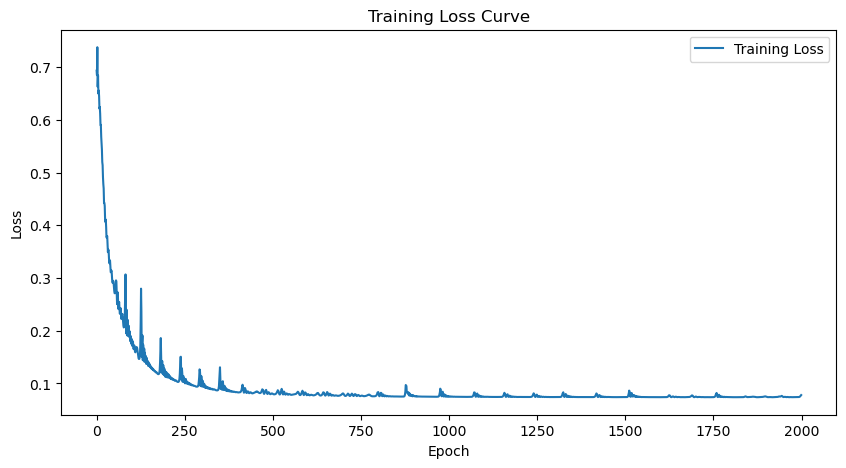

Final Model Accuracy: 82.11%
Final Model F1-score: 0.8350


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



/tmp/ipykernel_246694/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
